In [1]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from palette import PaletteRGB, compute_metrics_vector
import glob
from typing import OrderedDict

In [2]:
# Returns the index of a certain key in a dictionary.
def from_key_to_index(dictionary, key):
    return list(dictionary.keys()).index(key)

# Converts image from (H, W, D) to (D, H, W) by swapping its axes.
def from_HWD_to_DHW(img_HWD):
    return img_HWD.swapaxes(0, 2).swapaxes(1, 2)

# Converts image from (D, H, W) to (H, W, D) by swapping its axes.
def from_DHW_to_HWD(img_DHW):
    return img_DHW.swapaxes(0, 2).swapaxes(0, 1)

# Returns a boolean numpy array of shape (H, W), where each pixel (x, y) is True if img[x, y, :] is equal to color_triplet.
# ---
# img: numpy array with shape (H, W, 3).
# color_triplet: python list representing a color.
def color_mask(img, color_triplet=[0, 0, 0]):
    assert(img.shape[2] == 3 and len(color_triplet) == 3)

    img_DHW = from_HWD_to_DHW(img)
    ch0, ch1, ch2 = color_triplet
    mask = (img_DHW[0] == ch0) * (img_DHW[1] == ch1) * (img_DHW[2] == ch2)
    return mask

# Given a segmented image and a dictionary of labels, each corresponding to a different region of an image, returns a numpy 
# array of shape (H, W, n_labels) containing n_labels segmentation masks, where each one is a boolean numpy array 
# of shape (H, W) identifying pixels which belong to the corresponding label.
# ---
# labels: dictionary of labels { label_name (string): color_triplet (list) }.
def compute_segmentation_masks(img_segmented, labels):
    n_labels = len(labels)
    H, W, _ = img_segmented.shape
    masks = np.zeros((H, W, n_labels), dtype=np.float32)

    for idx, label in enumerate(labels):
        label_color = labels[label]
        masks[:, :, idx] = color_mask(img_segmented, label_color)

    return masks

# Given an image of shape (H, W, D) and a set of masks represented by a boolean numpy array of shape (H, W, n_masks), applies 
# all masks to the image, resulting in a new image with shape (n_masks, H, W, D).
# ---
def apply_masks(img, masks):
    assert(img.shape[0] == masks.shape[0] and img.shape[1] == masks.shape[1])

    img_masked = np.expand_dims(img, axis=0) * np.expand_dims(from_HWD_to_DHW(masks), axis=3)
    return img_masked.astype(np.uint8)

# Converts two RGB colors, represented by numpy arrays of shape (1, 1, 3), in CIELab and then computes
# the euclidean distance between them.
def color_distance(color1_RGB, color2_RGB):
    assert(color1_RGB.shape == (1, 1, 3) and color2_RGB.shape == (1, 1, 3))
    
    color1_CIELab = cv2.cvtColor(color1_RGB, cv2.COLOR_RGB2Lab)
    color2_CIELab = cv2.cvtColor(color2_RGB, cv2.COLOR_RGB2Lab)
    return np.linalg.norm(color1_RGB - color2_RGB)

# Converts two images of shape (H, W, D) in CIELab and then computes the RMSE between them.
def rmse(img1, img2):
    assert(img1.shape == img2.shape)

    H, W, _ = img1.shape
    img1_CIELab = cv2.cvtColor(img1, cv2.COLOR_RGB2Lab)
    img2_CIELab = cv2.cvtColor(img2, cv2.COLOR_RGB2Lab)

    return (((img1_CIELab - img2_CIELab) ** 2).sum() / (H * W)) ** 0.5

# Given a masked image of shape (n_masks, H, W, D) and a distance function computing a distance measure between two images, 
# returns a numpy array of shape (n_masks, 1, 1, D) containing the dominant colors associated to each mask.
# ---
# n_candidates: tuple of length n_masks specifying how many candidates to consider for each mask when looking for a dominant.
def compute_dominants(img_masked, n_candidates, distance_fn, debug=False):
    assert(img_masked.shape[0] == len(n_candidates))

    n_masks, H, W, D = img_masked.shape
    dominants = []

    for i in range(n_masks):
        img_masked_i = img_masked[i]
        kmeans = KMeans(n_clusters=n_candidates[i], random_state=99)
        mask = np.logical_not(color_mask(img_masked_i))                
        img_masked_i_flattened = img_masked_i.reshape((H * W, -1)) / 255
    
        kmeans.fit(img_masked_i_flattened)
        candidates = np.round(kmeans.cluster_centers_ * 255).astype(np.uint8)
    
        min_reconstruction_error = -1 
        dominant = np.zeros((1, 1, D), dtype=np.uint8)

        for color_triplet in candidates:
            img_reconstructed_i = np.expand_dims(mask, axis=2) * np.array([[color_triplet]])
            reconstruction_error = distance_fn(img_masked_i, img_reconstructed_i)

            # debug
            if debug is True:
                r, g, b = color_triplet
                print(f'candidate: ({r},{g},{b}), error: {reconstruction_error}')
                plt.figure(figsize=(16, 8))
                plt.subplot(1, 2, 1)
                plt.imshow(img_reconstructed_i) 
                plt.subplot(1, 2, 2)
                plt.imshow(img_masked_i) 
                plt.show() 

            if min_reconstruction_error == -1 or reconstruction_error < min_reconstruction_error:
                min_reconstruction_error = reconstruction_error
                dominant[0, 0, :] = color_triplet
            
        dominants.append(dominant)
    
    return np.array(dominants, dtype=np.uint8).reshape((n_masks, 1, 1, D))

# Computes subtone (S) by comparing lips color with colors peach and purple according to the following rule:
# if lips_color is closest to peach_color then subtone is 'warm'
# else if lips_color is closest to purple_color then subtone is 'cold'
# ---
# lips_color: numpy array of shape (1, 1, 3).
def compute_subtone(lips_color): 
    peach_color = np.array([255, 230, 182], dtype=np.float32).reshape((1, 1, 3)) / 255
    purple_color = np.array([145, 0, 255], dtype=np.float32).reshape((1, 1, 3)) / 255

    if color_distance(lips_color, peach_color) < color_distance(lips_color, purple_color):
        return 'warm'
    
    return 'cold'

# Computes contrast (C), defined as the brightness difference between hair and eyes.
# ---
# hair_color, eyes_color: numpy arrays of shape (1, 1, 3).
def compute_contrast(hair_color, eyes_color): 
    hair_color_GRAYSCALE = cv2.cvtColor(hair_color, cv2.COLOR_RGB2GRAY).item()
    eyes_color_GRAYSCALE = cv2.cvtColor(eyes_color, cv2.COLOR_RGB2GRAY).item()
    return abs(hair_color_GRAYSCALE - eyes_color_GRAYSCALE) / 255

# Computes intensity (I), defined as skin color saturation.
# ---
# skin_color: numpy array of shape (1, 1, 3).
def compute_intensity(skin_color): 
    skin_color_HSV = cv2.cvtColor((skin_color / 255).astype(np.float32), cv2.COLOR_RGB2HSV)
    return skin_color_HSV[0, 0, 1]

# Computes value (V), defined as the overall brightness of skin, hair and eyes.
# ---
# skin_color, hair_color, eyes_color: numpy arrays of shape (1, 1, 3).
def compute_value(skin_color, hair_color, eyes_color): 
    skin_color_GRAYSCALE = cv2.cvtColor((skin_color / 255).astype(np.float32), cv2.COLOR_RGB2GRAY).item()
    hair_color_GRAYSCALE = cv2.cvtColor((hair_color / 255).astype(np.float32), cv2.COLOR_RGB2GRAY).item()
    eyes_color_GRAYSCALE = cv2.cvtColor((eyes_color / 255).astype(np.float32), cv2.COLOR_RGB2GRAY).item()
    return (skin_color_GRAYSCALE + hair_color_GRAYSCALE + eyes_color_GRAYSCALE) / 3

# Assigns to palette a class taken from reference_palettes, by minimizing the Hamming distance
# between metrics vectors (see PaletteRGB class in palette.py).
def classify_palette(palette, reference_palettes):
    assert(palette.has_metrics_vector())

    min_hamming_distance = -1
    season = PaletteRGB()
    metrics_vector = palette.metrics_vector()
    
    for reference_palette in reference_palettes:
        assert(reference_palette.has_metrics_vector())

        reference_metrics_vector = reference_palette.metrics_vector()

        if reference_metrics_vector[0] != metrics_vector[0]:
            continue

        hamming_distance = (metrics_vector != reference_metrics_vector).sum()

        if min_hamming_distance == -1 or hamming_distance < min_hamming_distance:
            min_hamming_distance = hamming_distance
            season = reference_palette
    
    return season

autumn


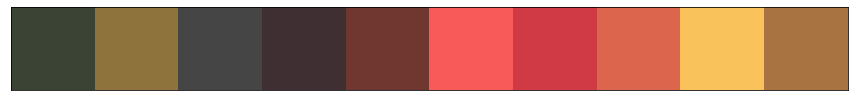

spring


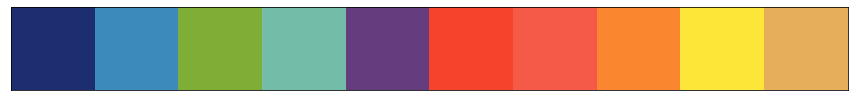

summer


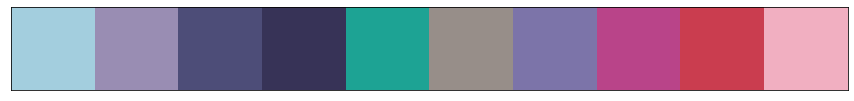

winter


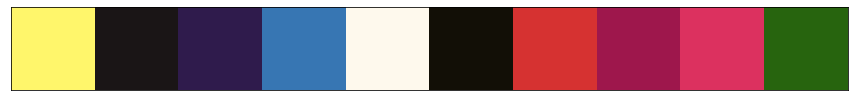

In [3]:
palettes_dir = 'palettes'
reference_palettes = [PaletteRGB().load(palette_filename.replace('\\', '/'), header=True) for palette_filename in glob.glob(palettes_dir + '/*.csv')]

for reference_palette in reference_palettes:
  print(reference_palette.description())
  reference_palette.plot(tile_size=15)

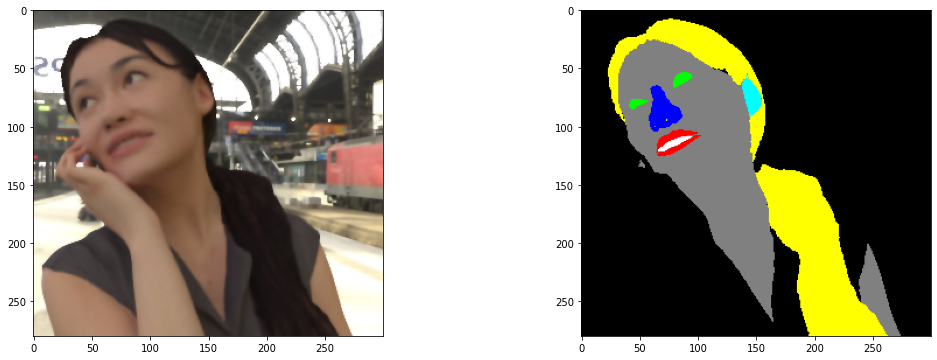

candidate: (0,0,0), error: 7.932365136998338


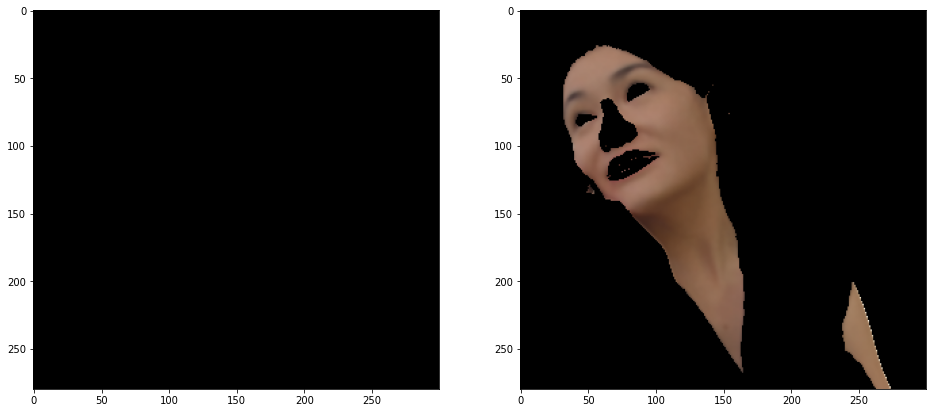

candidate: (138,100,79), error: 4.264367870310128


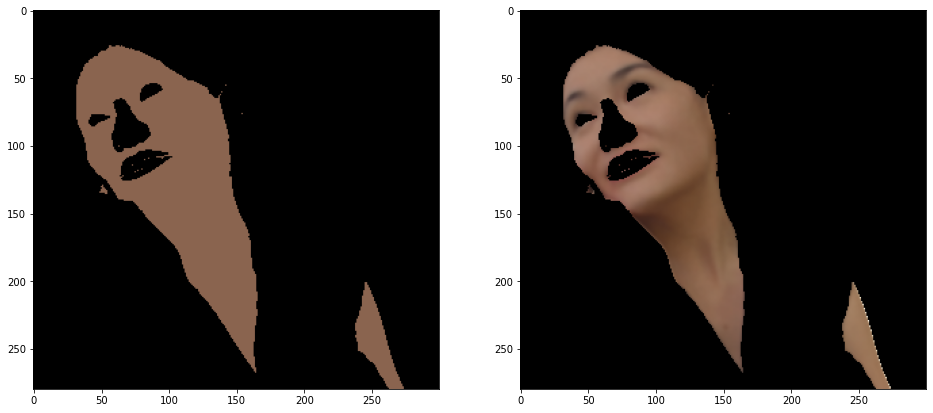

candidate: (0,0,0), error: 4.305703581684802


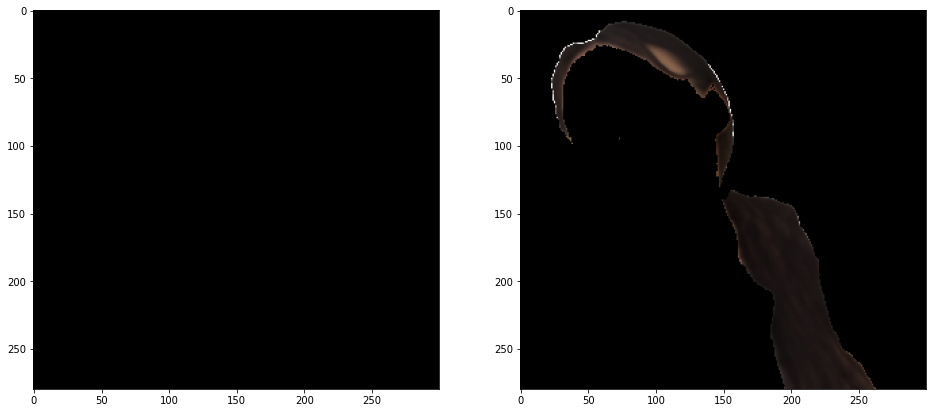

candidate: (39,30,27), error: 3.7918003639432287


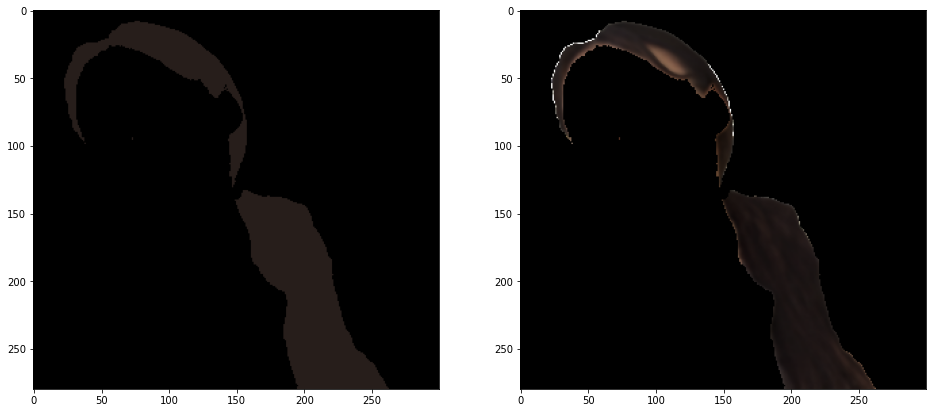

candidate: (0,0,0), error: 1.3342288659246833


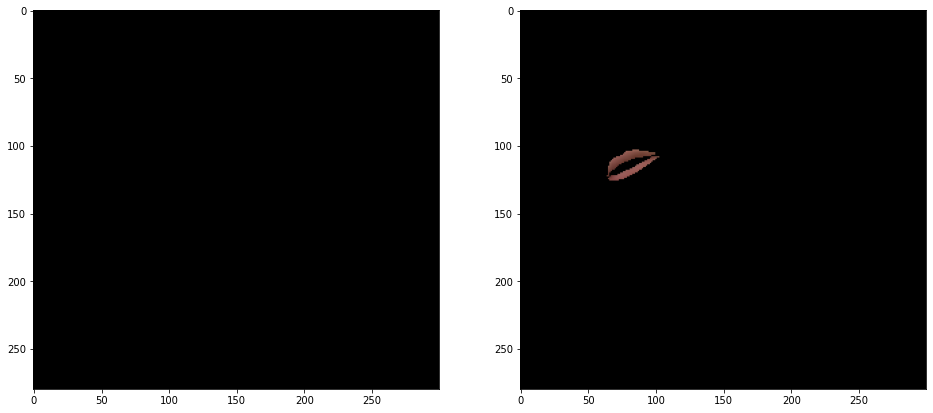

candidate: (132,79,71), error: 0.6612038083605358


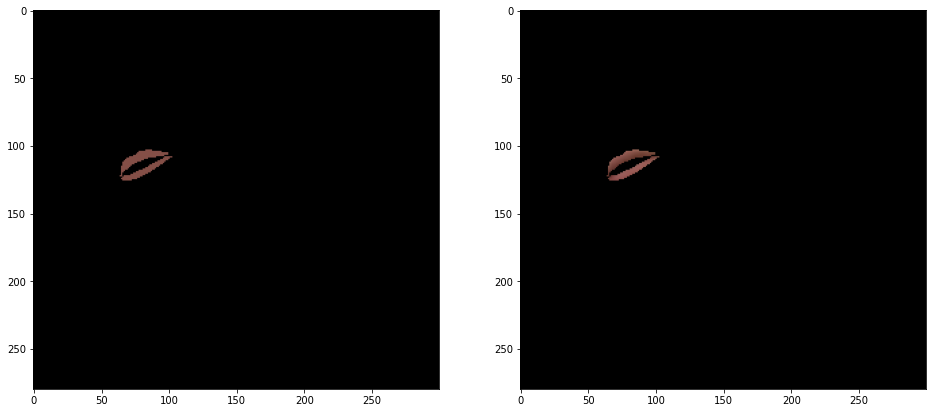

candidate: (0,0,0), error: 0.817764082873597


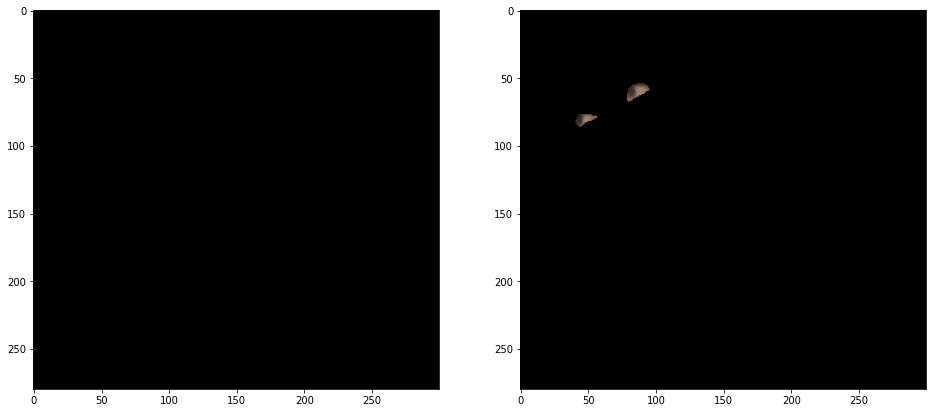

candidate: (134,111,98), error: 0.5812957611274676


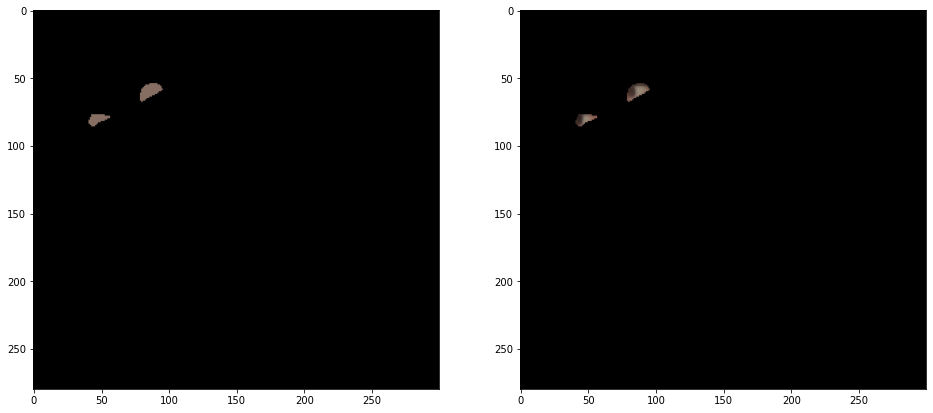

candidate: (72,54,48), error: 0.5735021899738151


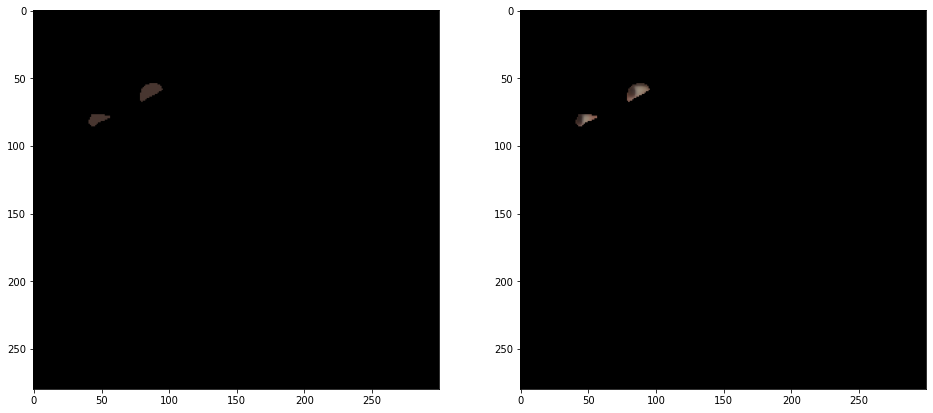

dominants palette:


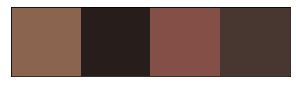

S: warm, I: 0.42753615975379944, V: 0.26145752767721814, C: 0.10588235294117647, season: autumn


In [4]:
# Assigns a specific color to each relevant region of a segmented image.
labels = OrderedDict({
    'skin': [128, 128, 128],
    'hair': [255, 255, 0],
    'lips': [255, 0, 0],
    'eyes': [0, 255, 0],
})


bilateral_filter_size = 5
bilateral_filter_sigma = 125

# test data
fig1 = cv2.cvtColor(cv2.imread('images/fig1.png'), cv2.COLOR_BGR2RGB)
fig1 = cv2.bilateralFilter(fig1, d=bilateral_filter_size, sigmaColor=bilateral_filter_sigma, sigmaSpace=bilateral_filter_sigma)
figseg1 = cv2.cvtColor(cv2.imread('images/figseg1.png'), cv2.COLOR_BGR2RGB)
fig2 = cv2.cvtColor(cv2.imread('images/fig2.png'), cv2.COLOR_BGR2RGB)
fig2 = cv2.bilateralFilter(fig2, d=bilateral_filter_size, sigmaColor=bilateral_filter_sigma, sigmaSpace=bilateral_filter_sigma)
figseg2 = cv2.cvtColor(cv2.imread('images/figseg2.png'), cv2.COLOR_BGR2RGB)

img, img_segmented = fig1, figseg1

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.savefig('fig1_blurred.png')
plt.subplot(1, 2, 2)
plt.imshow(img_segmented)
plt.show()

# step 1: compute segmentation masks for skin, hair, lips, eyes from segmented images (in this order)
masks = compute_segmentation_masks(img_segmented, labels)

# step 2: extract colors of skin, hair, lips and eyes using segmentation masks (in this order)
img_masked = apply_masks(img, masks)
dominants = compute_dominants(img_masked, n_candidates=(2, 2, 2, 3), distance_fn=rmse, debug=True)
dominants_palette = PaletteRGB('dominants', dominants)
print('dominants palette:')
dominants_palette.plot()

# step 3: compute color harmony metrics (subtone, intensity, value, contrast) and metrics_vector 
#         (a binary numpy array of format SIVC obtained by binarizing the metrics)
skin_idx = from_key_to_index(labels, 'skin')
hair_idx = from_key_to_index(labels, 'hair')
lips_idx = from_key_to_index(labels, 'lips')
eyes_idx = from_key_to_index(labels, 'eyes')
subtone = compute_subtone(dominants[lips_idx])
intensity = compute_intensity(dominants[skin_idx])
value = compute_value(dominants[skin_idx], dominants[hair_idx], dominants[eyes_idx])
contrast = compute_contrast(dominants[hair_idx], dominants[eyes_idx])
dominants_palette.set_metrics_vector(compute_metrics_vector(subtone, intensity, value, contrast))

# step 4: Pick season which minimizes Hamming distance between metrics vectors, choosing among seasons with 
#         same subtone
dominants_metrics_vector = compute_metrics_vector(subtone, intensity, value, contrast)
dominants_palette.set_metrics_vector(dominants_metrics_vector)
season_palette = classify_palette(dominants_palette, reference_palettes)
print(f'S: {subtone}, I: {intensity}, V: {value}, C: {contrast}, season: {season_palette.description()}')

# step 4bis: find optimized thresholds for I, V, C
#            possible solution approach:
#            --> C/I: pick images of autumn/summer for low C/I and winter/spring for high C/I, then compute 
#                     max low C/I and min high C/I, confront these with C/I of current image to choose if high or low
#            --> V: pick images of autumn for low value and summer/spring/winter for high value, then proceed as for C/I
